# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU.

**Make sure you use the best practices you learned in class**.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the entire CIFAR-10 dataset
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define the ratio for splitting into training and validation sets
train_ratio = 0.8
train_size = int(train_ratio * len(full_trainset))
val_size = len(full_trainset) - train_size

# Split the dataset into training and validation sets
trainset, valset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

# Create DataLoader for training and validation sets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)

# Load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
     plane       frog      plane       deer


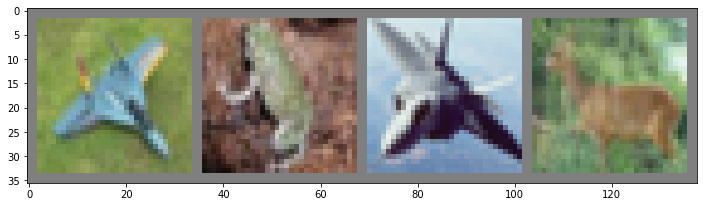

In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)

# get some random training images
dataiter = iter(trainloader)
# images, labels = dataiter.next()
images, labels = next(dataiter)


print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value.

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class.
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs.
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Experiment with the architecture to potentially make it faster.           #
        #############################################################################
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.logSoftMax = nn.LogSoftmax(dim = 1)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the prediction of your model.                        #
        #############################################################################
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)  # Adjusted based on the new architecture
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.logSoftMax(x)
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################



net = Net()

criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   #
#############################################################################

# Loss function: CrossEntropy
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam. Default Parameters as in class (alpha=0.9, beta=0.999, epsilon=1e-8)
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Use StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [6]:
def train(net, trainloader, valloader, criterion, optimizer, scheduler=None, use_gpu=True, num_epochs=10):
    """
    Train the specified neural network using the provided data.

    Parameters:
    - net: The neural network to be trained.
    - trainloader: DataLoader for the training dataset.
    - valloader: DataLoader for the validation dataset.
    - criterion: Loss function.
    - optimizer: The optimization algorithm.
    - scheduler: (Optional) A learning rate scheduler.
    - use_gpu: Boolean, if True, use CUDA if available.
    - num_epochs: Number of epochs for training.

    Returns:
    - A dictionary containing training loss, training accuracy, validation loss, and validation accuracy history.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")
    net.to(device)
    criterion.to(device)

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []  # Added to track validation loss history
    val_acc_history = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        accuracy = correct_predictions / total_samples
        train_loss_history.append(running_loss / len(trainloader))
        train_acc_history.append(accuracy)

        net.eval()
        val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0

        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val_samples += labels.size(0)
                correct_val_predictions += (predicted == labels).sum().item()

        val_accuracy = correct_val_predictions / total_val_samples
        val_loss_history.append(val_loss / len(valloader))  # Store validation loss
        val_acc_history.append(val_accuracy)

        print(f'Epoch {epoch + 1} - Training Loss: {train_loss_history[-1]:.3f}, '
              f'Training Accuracy: {train_acc_history[-1] * 100:.2f}%, '
              f'Validation Loss: {val_loss_history[-1]:.3f}, '
              f'Validation Accuracy: {val_acc_history[-1] * 100:.2f}%')

        if scheduler:
            scheduler.step()

    print('Finished Training')
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [7]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(net=net, trainloader=trainloader,valloader=valloader,criterion=criterion, optimizer=optimizer, scheduler=scheduler)

Epoch 1 - Training Loss: 1.221, Training Accuracy: 55.82%, Validation Loss: 0.980, Validation Accuracy: 65.53%
Epoch 2 - Training Loss: 0.854, Training Accuracy: 69.99%, Validation Loss: 0.826, Validation Accuracy: 70.84%
Epoch 3 - Training Loss: 0.716, Training Accuracy: 74.80%, Validation Loss: 0.748, Validation Accuracy: 74.13%
Epoch 4 - Training Loss: 0.621, Training Accuracy: 78.42%, Validation Loss: 0.773, Validation Accuracy: 72.79%
Epoch 5 - Training Loss: 0.532, Training Accuracy: 81.28%, Validation Loss: 0.753, Validation Accuracy: 74.42%
Epoch 6 - Training Loss: 0.459, Training Accuracy: 84.01%, Validation Loss: 0.701, Validation Accuracy: 76.41%
Epoch 7 - Training Loss: 0.388, Training Accuracy: 86.30%, Validation Loss: 0.689, Validation Accuracy: 77.27%
Epoch 8 - Training Loss: 0.325, Training Accuracy: 88.49%, Validation Loss: 0.736, Validation Accuracy: 76.86%
Epoch 9 - Training Loss: 0.280, Training Accuracy: 90.05%, Validation Loss: 0.678, Validation Accuracy: 78.90%
E

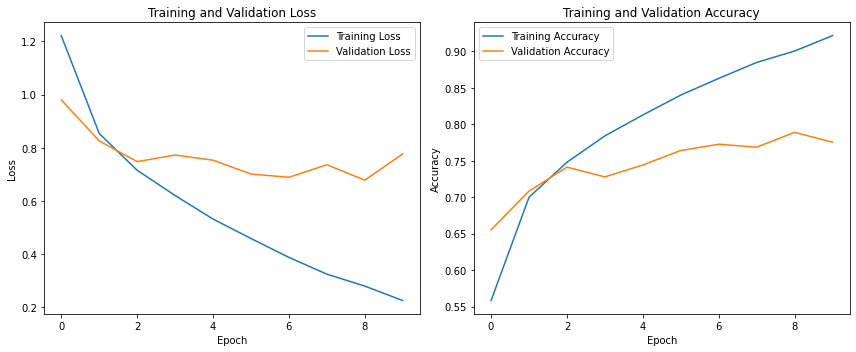

In [8]:
# Visualization of training and validation loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plotting Training and Validation Loss
axes[0].plot(train_loss_history, label='Training Loss')
axes[0].plot(val_loss_history, label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting Training and Validation Accuracy
axes[1].plot(train_acc_history, label='Training Accuracy')
axes[1].plot(val_acc_history, label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)**

In [9]:

confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        #
#############################################################################
# Define device for evaluation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Ensure the model is in evaluation mode
net.eval()

# Initialize counters for correct predictions and total samples
correct_predictions = 0
total_samples = 0

# Use torch.no_grad() to disable gradient calculation, which is unnecessary for evaluation or inference.
with torch.no_grad():

  # Iterate over the test set
    for images, labels in testloader:

        # Move the images and labels to the specified 'device'
        images, labels = images.to(device), labels.to(device)

        # Forward pass: compute the network's output for the input images.
        outputs = net(images)

        # Get the predicted classes for each image in the batch using torch.max.
        # returns the maximum values in the output tensor and their indices (i.e., the classes with the highest scores).
        _, predicted = torch.max(outputs, 1)

        # Update confusion matrix
        for label, prediction in zip(labels, predicted):
            confusion_matrix[label.item(), prediction.item()] += 1

# Calculate accuracy after this block
correct_predictions = sum([confusion_matrix[i, i] for i in range(10)])
total_samples = confusion_matrix.sum()
model_accuracy = 100 * correct_predictions / total_samples
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 77.02%


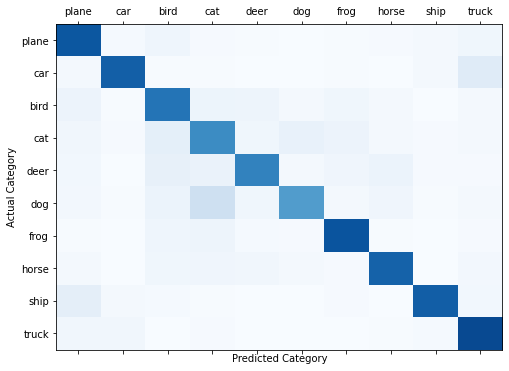

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:**
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:**

In my efforts to enhance a neural network model for CIFAR-10, I focused on architectural adjustments, regularization, and optimization to improve both performance and efficiency. Below are the key insights:

**Network Depth and Width:**

 A complex, deep, and wide network initially seemed promising but led to overfitting and high computational costs. Simplifying the architecture by reducing layers and narrowing the width improved manageability and model generalization.

**Pooling Layers:**

 Integrating additional pooling layers effectively reduced feature map dimensions, which decreased computational demands and accelerated training. This adjustment also improved feature extraction through spatial invariance.

**Dropout and Batch Normalization:**

 Implementing dropout layers helped combat overfitting by randomly deactivating units during training. Batch normalization, applied alongside dropout, normalized layer inputs, stabilizing and speeding up the learning process. This technique facilitated the use of higher learning rates and reduced the need for precise initialization, indirectly enhancing the training dynamics.

**Optimization Techniques:**

Adaptive Learning Rates: Utilizing the Adam optimizer, known for its adaptive learning rate adjustments, significantly sped up model convergence. A learning rate scheduler further fine-tuned this process by dynamically modifying the learning rate, optimizing training results.


**Activation, Loss Functions, and Output Layer:**


**Activation Function**: The ReLU function was selected for its efficiency and ability to prevent the vanishing gradient problem, outperforming other functions like sigmoid and tanh.
Output Layer: I incorporated a softmax layer as the final step in the network to convert the logits into probabilities, providing a clear, normalized output for classification.

**Loss Function**: Cross Entropy Loss was chosen due to its effectiveness in multi-class classification scenarios. It excels at quantifying the difference between the predicted probability distribution and the actual distribution, making it ideal for this project.

**Output Layer**: A softmax layer was incorporated as the final step in the model. This layer is crucial for converting the logits into a probability distribution over the classes, ensuring the output is both normalized and interpretable for classification purposes.


**Conclusion**


My approach, centering on deliberate architectural and optimization modifications, led to significant advancements in accuracy and efficiency. Strategic use of dropout, batch normalization, adaptive learning rates, and the ReLU activation function, combined with the softmax output layer and Cross Entropy Loss, were pivotal. These adjustments highlight the importance of a balanced network design and thoughtful optimization in achieving high performance in image classification tasks.

##**Question:**
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:**

This confusion matrix provides a comprehensive overview of a classification model's performance across different categories, highlighting not just the successes but also instances where the model confuses one class for another.

While accuracy offers a summary of overall performance, it can be misleading, especially in datasets with class imbalance, where it might disproportionately emphasize the majority class's influence.

The confusion matrix allows us to identify which classes are frequently confused by observing the 'bluer' cells—for example, it can show that cats are sometimes predicted as dogs, trucks as cars, birds as planes, and vice versa.

In conclusion, the confusion matrix is invaluable for diagnosing model performance beyond mere accuracy, revealing nuances in how different classes are handled and guiding targeted improvements in the model, particularly for classes that are easily confused or underrepresented.

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs.

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images.

In [28]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

# sys.path.append('/content/gdrive/My Drive/Colab_Notebooks/data')
# os.chdir('/content/gdrive/My Drive/Colab_Notebooks')
# from dataloader import *

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [29]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [30]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [31]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 864x576 with 0 Axes>

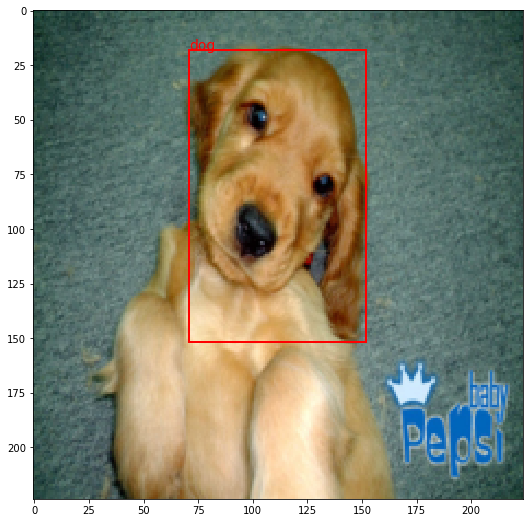

In [32]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

    plt.show()

imshow(sample['image'],sample['label'],sample['bbox'])

In [33]:
class CNN(nn.Module):
    def __init__(self, num_classes, pretrained_resnet=resnet18):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only       #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # Clarrification - You required to build 2 models - one for classification  #
        # and one for detection.                                                    #
        # The classification model is of shape: resent_features -> FC/FCs -> scores.#
        # The detection model is of shape: resent_features -> FC/FCs -> bbox.       #
        # You may train/leave frozen the resent_features backbone, try              #
        # experimenting with it.                                                    #
        # This function has no return value.                                        #
        #############################################################################
        # Use the passed pretrained ResNet-18 model
        # self.resnet = pretrained_resnet
        self.resnet = copy.deepcopy(pretrained_resnet)

        # Freeze the weights of the pretrained ResNet-18 model
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Remove the original fully connected layer of ResNet-18
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Use ResNet-18 as a fixed feature extractor

        # Define the size of the shared layer as a fraction of num_features
        # For a narrower model, use num_features // 2 or num_features // 4
        shared_layer_size = num_features // 2  # Adjust as needed

        # Define shared layers for both classification and detection tasks
        self.shared_layers = nn.Sequential(
            nn.Linear(num_features, shared_layer_size),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        # Define the final layers for classification and detection
        self.final_classification = nn.Linear(shared_layer_size, num_classes)
        self.final_bbox = nn.Linear(shared_layer_size, 4)


        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################


        # Pass the input images through the pre-trained ResNet-18 network
        features = self.resnet(images)

        # Flatten the features for the fully connected layers
        features = torch.flatten(features, start_dim=1)

        # Pass the flattened features through the shared fully connected layer(s)
        shared_features = self.shared_layers(features)

        # Predict the class scores using the class scores model
        class_scores = self.final_classification(shared_features)

        # Predict the bounding box coordinates using the bounding box coordinates model
        bbox_coords = self.final_bbox(shared_features)

        return class_scores, bbox_coords


        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set.
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [34]:
def train_model(model, dataloaders, dataset_sizes, criterion_cls, criterion_bbox, optimizer, scheduler=None, use_gpu=True, num_epochs=5, loss_cls_weight=0.025):
    """
    Train a model for both classification and bounding box detection.

    Parameters:
    - model: The neural network model to train.
    - dataloaders: A dictionary containing the 'train' and 'val' DataLoaders.
    - dataset_sizes: A dictionary containing the size of the datasets for 'train' and 'val'.
    - criterion_cls: The loss function for the classification task.
    - criterion_bbox: The loss function for the bounding box detection task.
    - optimizer: The optimization algorithm.
    - scheduler: (Optional) A learning rate scheduler.
    - use_gpu: Boolean indicating whether to use a GPU if available.
    - num_epochs: The number of epochs to train the model.
    - loss_cls_weight (float): the weight for the classification loss

    Returns:
    - model: The trained model with the best validation accuracy
    - metrics: A dictionary containing training and validation loss, accuracy, and IoU.
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")
    model.to(device)

    # Initialize dictionaries to hold training and validation metrics
    metrics = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_iou': [], 'val_iou': []
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # for each epoch run the model over train and val set and set the model respectively
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model to training mode
            else:
                model.eval()   # Set the model to evaluate mode

            running_loss = 0.0
            correct_predictions = 0
            total_iou = 0.0  # Total IoU for the epoch
            total_samples = 0  # Total number of samples processed

            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                images = sample['image'].to(device)
                labels = sample['label'].to(device)
                bboxes = sample['bbox'].to(device)

                optimizer.zero_grad()  # Zero the gradients on each iteration

                with torch.set_grad_enabled(phase == 'train'):
                    class_scores, bbox_coords = model(images)  # Forward pass

                    # Calculate loss for both outputs
                    loss_cls = criterion_cls(class_scores, labels)
                    loss_bbox = criterion_bbox(bbox_coords, bboxes)

                   # Combine losses according to the loss_cls_weight parameter
                    loss = (loss_cls_weight * loss_cls) + ((1 - loss_cls_weight) * loss_bbox)

                    # backprop only in train mode
                    if phase == 'train':
                        loss.backward()  # Backpropagation
                        optimizer.step()  # Optimize

                _, preds = torch.max(class_scores, 1)
                correct_predictions += torch.sum(preds == labels.data)

                # bb_intersection_over_union is implemented in dataloader module

                for i in range(len(bboxes)):
                    iou_score = bb_intersection_over_union(bbox_coords[i].cpu().detach(), bboxes[i].cpu().detach())
                    total_iou += iou_score
                 # Update Total samples
                total_samples += bboxes.size(0)

                # Aggregate losses
                running_loss += loss.item() * images.size(0)
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (correct_predictions.double() / dataset_sizes[phase]).item()  # Convert to scalar
            # Compute epoch IoU
            epoch_iou = (total_iou / total_samples).item()  # Convert to scalar


            metrics[f'{phase}_loss'].append(epoch_loss)
            metrics[f'{phase}_acc'].append(epoch_acc)
            metrics[f'{phase}_iou'].append(epoch_iou)


            print('{} Loss: {:.4f} Acc: {:.4f} IOU: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_iou))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step()  # Adjust the learning rate based on the scheduler

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [35]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()
optimizer = optim.AdamW(cnn.parameters(), lr=0.001, weight_decay=0.01)
# Define a scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [36]:
best_model, best_metrics = train_model(model=cnn, dataloaders=dataloaders, dataset_sizes=dataset_sizes, criterion_cls=criterion_cls, criterion_bbox=criterion_bbox, optimizer=optimizer, scheduler=scheduler, use_gpu=True, num_epochs=10, loss_cls_weight=0.025)

Epoch 1/10
----------
train Loss: 0.0768 Acc: 0.5928 IOU: 0.5118
val Loss: 0.0331 Acc: 0.7532 IOU: 0.6594
Epoch 2/10
----------
train Loss: 0.0357 Acc: 0.8286 IOU: 0.6348
val Loss: 0.0217 Acc: 0.9810 IOU: 0.7288
Epoch 3/10
----------
train Loss: 0.0281 Acc: 0.8868 IOU: 0.6682
val Loss: 0.0172 Acc: 0.9873 IOU: 0.7364
Epoch 4/10
----------
train Loss: 0.0231 Acc: 0.9340 IOU: 0.6793
val Loss: 0.0142 Acc: 0.9810 IOU: 0.7386
Epoch 5/10
----------
train Loss: 0.0213 Acc: 0.9513 IOU: 0.6753
val Loss: 0.0121 Acc: 0.9873 IOU: 0.7429
Epoch 6/10
----------
train Loss: 0.0193 Acc: 0.9403 IOU: 0.6927
val Loss: 0.0114 Acc: 0.9937 IOU: 0.7436
Epoch 7/10
----------
train Loss: 0.0172 Acc: 0.9670 IOU: 0.7018
val Loss: 0.0106 Acc: 1.0000 IOU: 0.7470
Epoch 8/10
----------
train Loss: 0.0166 Acc: 0.9686 IOU: 0.7061
val Loss: 0.0103 Acc: 1.0000 IOU: 0.7517
Epoch 9/10
----------
train Loss: 0.0160 Acc: 0.9701 IOU: 0.7076
val Loss: 0.0099 Acc: 0.9937 IOU: 0.7544
Epoch 10/10
----------
train Loss: 0.0156 Acc:

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

<Figure size 864x576 with 0 Axes>

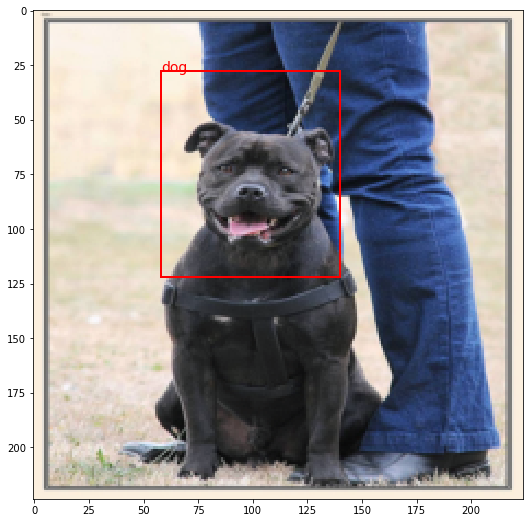

In [42]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)

    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

Few notes regarding the results:

Due to the pretrained parameters of ResNet, the model achieves high accuracy in the classsification task. There is a significant improvement in accuracy within the first 2-3 epochs, where the parameters are "fine-tuned" to complement the last layers. This is followed by a more gradual improvement in subsequent epochs.

The IOU does not surpass 0.75. While the classification task benefits from the adjustments made by leveraging ResNet, the object detection task, being inherently more complex, requires a more sophisticated network beyond the final fully connected (FC) layer of ResNet. Such extention layers to the existing architecture demand extensive computational resources, often exceeding the constraints of limited runtime environments.

The validation loss is lower than the training loss, and correspondingly, the validation IOU and accuracy are higher than those of the training phase. A plausible explanation is the difference in behavior of certain layers (like regularization layers) between training and evaluation modes. In training mode, layers such as batch normalization and dropout are active, leading to higher loss and lower accuracy during training epochs. Specifically, in the architecture I used, there's a dropout layer in the shared section following the ResNet backbone, along with any additional "training-specific" layers (like BN) present in the original ResNet architecture. These layers generally enhance network performance but can result in higher training loss and lower accuracy.


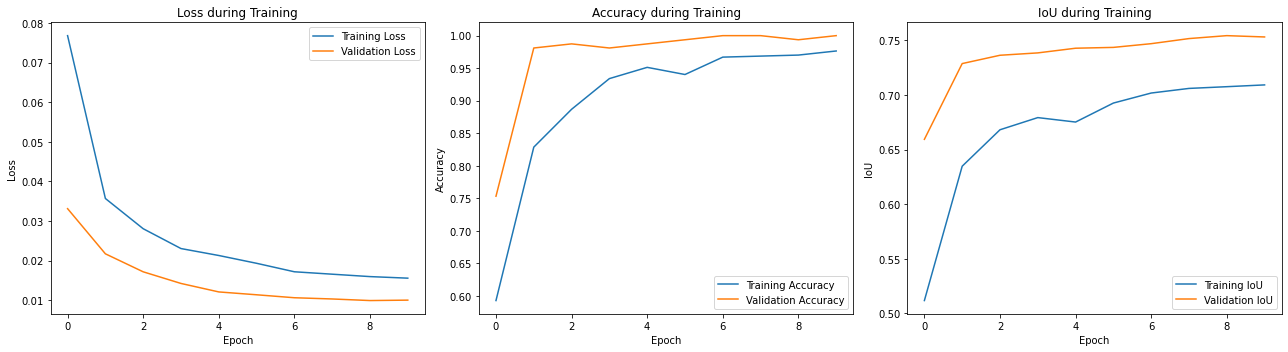

In [38]:
# Plotting with axes for more control
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot Training and Validation Loss
axes[0].plot(best_metrics['train_loss'], label='Training Loss')
axes[0].plot(best_metrics['val_loss'], label='Validation Loss')
axes[0].set_title('Loss during Training')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot Training and Validation Accuracy
axes[1].plot(best_metrics['train_acc'], label='Training Accuracy')
axes[1].plot(best_metrics['val_acc'], label='Validation Accuracy')
axes[1].set_title('Accuracy during Training')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Plot Training and Validation IoU
axes[2].plot(best_metrics['train_iou'], label='Training IoU')
axes[2].plot(best_metrics['val_iou'], label='Validation IoU')
axes[2].set_title('IoU during Training')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU')
axes[2].legend()

plt.tight_layout()
plt.show()